<a href="https://colab.research.google.com/github/Alfaruq193/Firestore/blob/master/KlaifikasiJentik_VisionTransvormer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 BAGIAN 1: Setup Lingkungan
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Setup selesai. Google Drive terhubung.

 BAGIAN 2: Konfigurasi
✅ Semua direktori dataset (train, validation, testing) berhasil ditemukan.
Menggunakan device: cpu

 BAGIAN 3: Memproses & Memuat Data
Kelas terdeteksi: ['aedes_albopictus', 'culex_quinquefasciatus']
Jumlah data -> Training: 2000, Validasi: 600, Testing: 100

 BAGIAN 4: Memuat & Melatih Model


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 1/3 -> Akurasi Train: 87.65% | Akurasi Val: 98.33%
  ✨ Model terbaik diperbarui & disimpan (Akurasi Validasi: 98.33%)


Epoch 2/3 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 2/3 -> Akurasi Train: 96.65% | Akurasi Val: 98.50%
  ✨ Model terbaik diperbarui & disimpan (Akurasi Validasi: 98.50%)


Epoch 3/3 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 3/3 -> Akurasi Train: 96.90% | Akurasi Val: 100.00%
  ✨ Model terbaik diperbarui & disimpan (Akurasi Validasi: 100.00%)

 BAGIAN 5: Evaluasi Akhir & Visualisasi


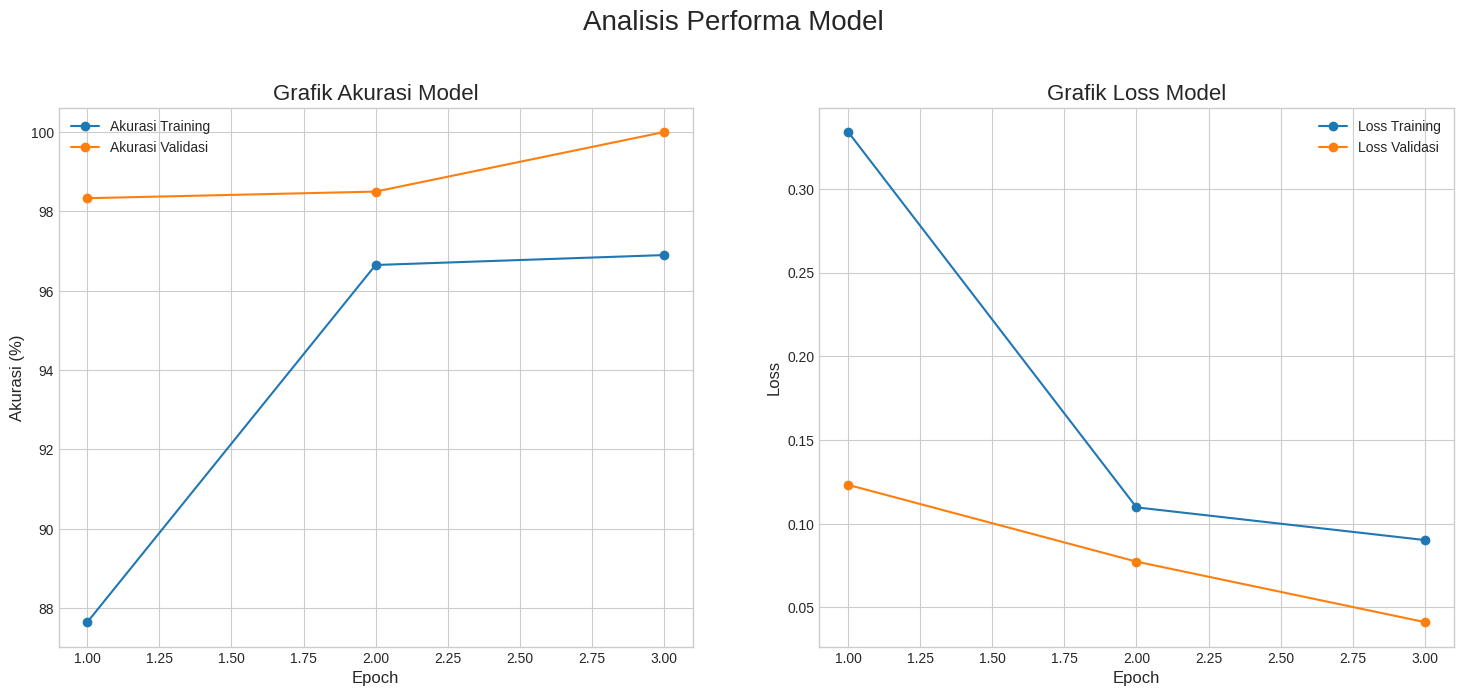


--- Mengevaluasi pada Data 'testing' ---


Testing:   0%|          | 0/7 [00:00<?, ?it/s]


Laporan Klasifikasi:
                        precision    recall  f1-score   support

      aedes_albopictus     0.9615    1.0000    0.9804        50
culex_quinquefasciatus     1.0000    0.9600    0.9796        50

              accuracy                         0.9800       100
             macro avg     0.9808    0.9800    0.9800       100
          weighted avg     0.9808    0.9800    0.9800       100



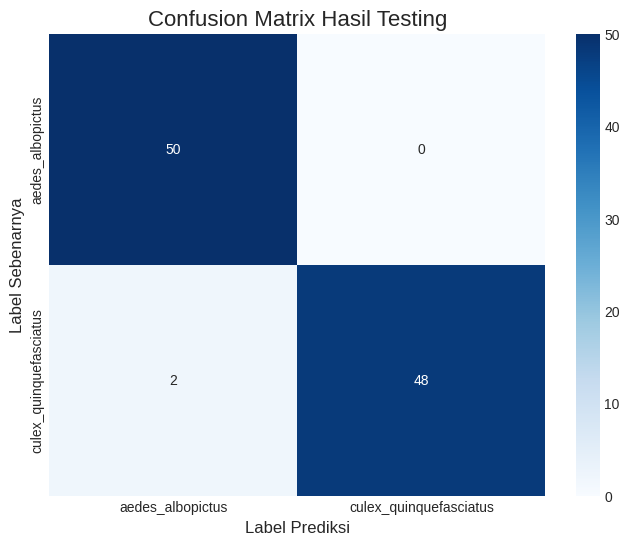


--- Visualisasi Contoh Prediksi pada Data 'testing' ---


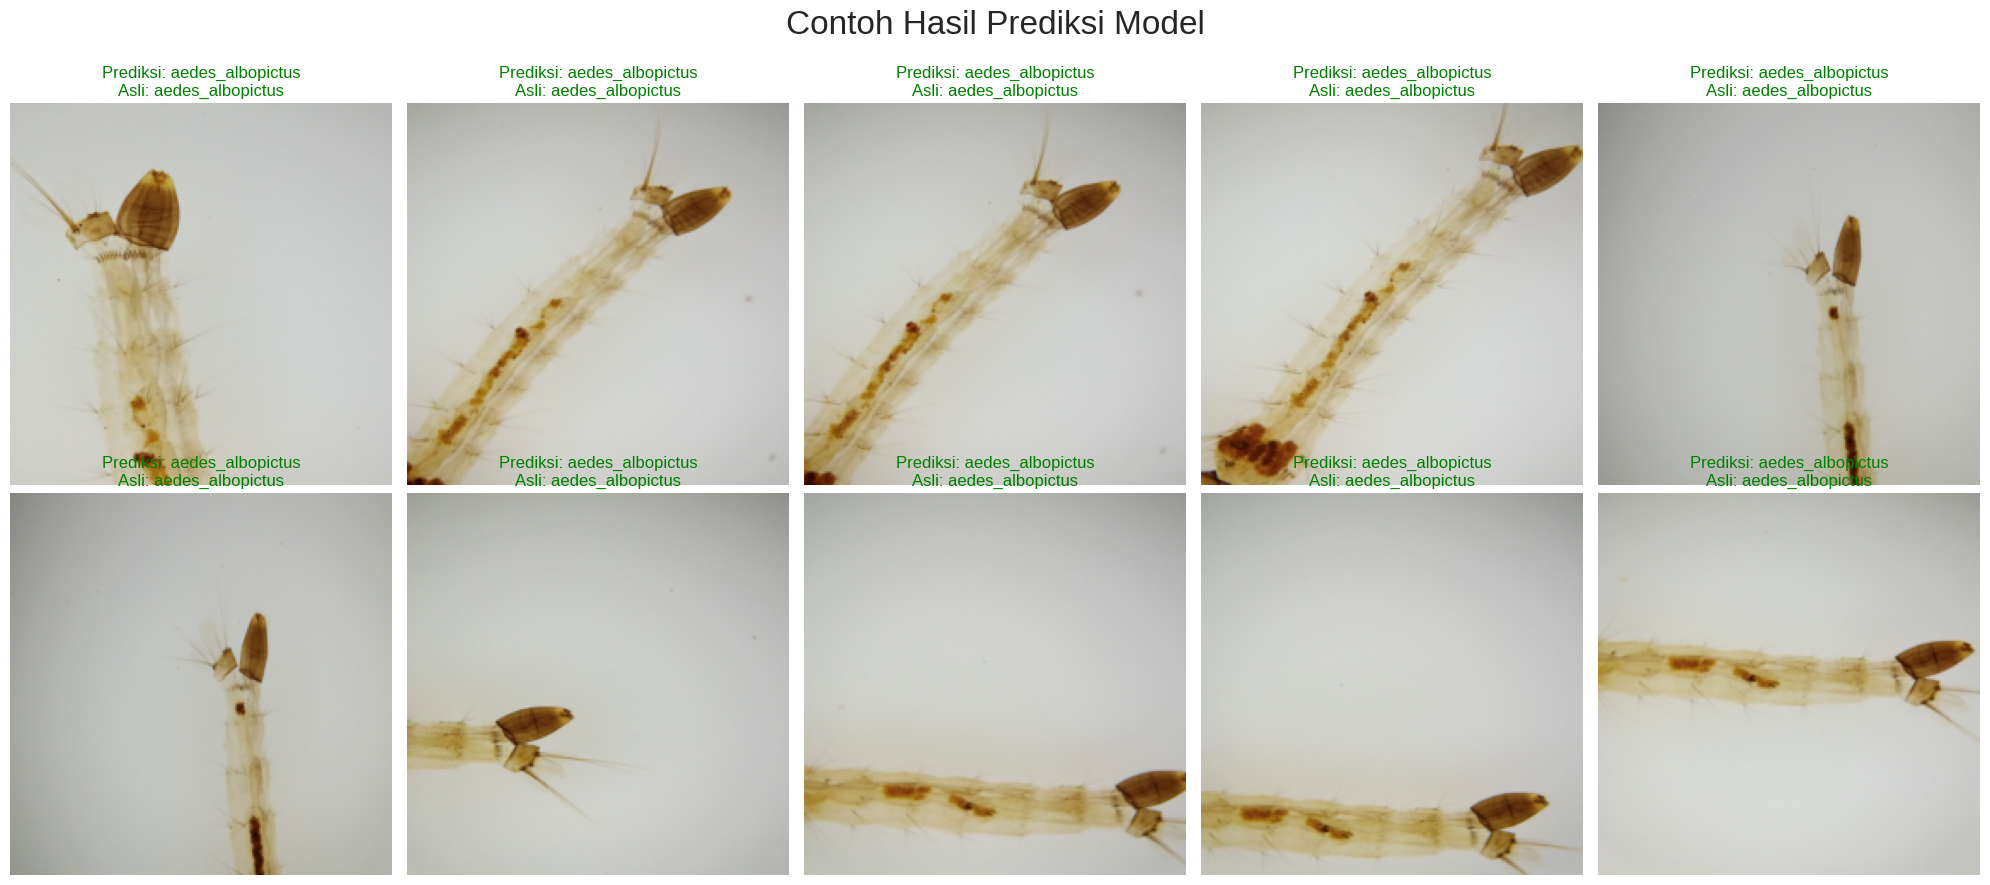


✅ Proses Selesai.


In [ ]:
# ==============================================================================
# BAGIAN 1: INSTALASI, IMPORT, DAN KONEKSI GOOGLE DRIVE
# ==============================================================================
print(" BAGIAN 1: Setup Lingkungan")

# Install library yang dibutuhkan
!pip install -q transformers datasets scikit-learn seaborn torch torchvision
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix

# Hubungkan Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("\n✅ Setup selesai. Google Drive terhubung.")

# ==============================================================================
# BAGIAN 2: KONFIGURASI PATH, MODEL, DAN HYPERPARAMETER
# ==============================================================================
print("\n BAGIAN 2: Konfigurasi")

# --- PATH DATASET ANDA ---
# Path utama ke dataset Anda di Google Drive
BASE_DIR = '/content/drive/MyDrive/dataset_jentik'

# Mendefinisikan path untuk setiap set data sesuai struktur Anda
TRAIN_DIR = os.path.join(BASE_DIR, 'training')
VAL_DIR = os.path.join(BASE_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DIR, 'testing')

# Verifikasi bahwa semua path direktori ada
for path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Direktori tidak ditemukan: {path}. Harap periksa kembali nama folder Anda.")
print("✅ Semua direktori dataset (train, validation, testing) berhasil ditemukan.")

# --- Konfigurasi Hyperparameter & Model ---
MODEL_NAME = 'google/vit-base-patch16-224-in21k'
NUM_EPOCHS = 3  # Anda bisa menambah epoch jika hasil kurang memuaskan
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

# Cek ketersediaan GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {DEVICE}")

# ==============================================================================
# BAGIAN 3: PREPROCESSING DAN MEMUAT DATA
# ==============================================================================
print("\n BAGIAN 3: Memproses & Memuat Data")

# Muat image processor dari model untuk konsistensi
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
image_mean, image_std = processor.image_mean, processor.image_std
image_size = processor.size['height']

# Definisikan transformasi data (dengan augmentasi untuk training)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std)
])

# Transformasi standar (tanpa augmentasi) untuk validasi dan testing
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std)
])

# Muat dataset menggunakan ImageFolder
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=eval_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=eval_transforms)

# Buat DataLoaders untuk memuat data dalam batch
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Kelas terdeteksi: {class_names}")
print(f"Jumlah data -> Training: {len(train_dataset)}, Validasi: {len(val_dataset)}, Testing: {len(test_dataset)}")
if len(train_dataset) == 0:
    raise ValueError("Tidak ada gambar yang ditemukan di folder training. Pastikan ada subfolder kelas di dalamnya.")

# ==============================================================================
# BAGIAN 4: MEMUAT DAN MELATIH MODEL VISION TRANSFORMER (ViT)
# ==============================================================================
print("\n BAGIAN 4: Memuat & Melatih Model")

# Muat model ViT pre-trained dan sesuaikan 'kepala' klasifikasinya
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to(DEVICE)

# Definisikan optimizer dan loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
# Dictionary untuk menyimpan riwayat training
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_accuracy = 0.0
# Loop training
for epoch in range(NUM_EPOCHS):
    # --- Fase Training ---
    model.train()
    total_train_loss, total_train_correct = 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]")

    for images, labels in progress_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs.logits, dim=1)
        total_train_correct += torch.sum(preds == labels).item()
    # --- Fase Validasi ---
    model.eval()
    total_val_loss, total_val_correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)

            total_val_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs.logits, dim=1)
            total_val_correct += torch.sum(preds == labels).item()

    # Hitung dan simpan metrik
    avg_train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct / len(train_dataset)
    avg_val_loss = total_val_loss / len(val_dataset)
    val_accuracy = total_val_correct / len(val_dataset)

    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} -> Akurasi Train: {train_accuracy*100:.2f}% | Akurasi Val: {val_accuracy*100:.2f}%")

    # Simpan model dengan akurasi validasi terbaik
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model_nyamuk.pth')
        print(f"  ✨ Model terbaik diperbarui & disimpan (Akurasi Validasi: {best_val_accuracy*100:.2f}%)")

# ==============================================================================
# BAGIAN 5: EVALUASI AKHIR & VISUALISASI HASIL
# ==============================================================================
print("\n BAGIAN 5: Evaluasi Akhir & Visualisasi")

# --- 5.1. Plot Grafik Akurasi & Loss ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

ax1.plot(range(1, NUM_EPOCHS + 1), [acc * 100 for acc in history['train_acc']], 'o-', label='Akurasi Training')
ax1.plot(range(1, NUM_EPOCHS + 1), [acc * 100 for acc in history['val_acc']], 'o-', label='Akurasi Validasi')
ax1.set_title('Grafik Akurasi Model', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Akurasi (%)', fontsize=12)
ax1.legend()

ax2.plot(range(1, NUM_EPOCHS + 1), history['train_loss'], 'o-', label='Loss Training')
ax2.plot(range(1, NUM_EPOCHS + 1), history['val_loss'], 'o-', label='Loss Validasi')
ax2.set_title('Grafik Loss Model', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()
plt.suptitle('Analisis Performa Model', fontsize=20, y=1.02)
plt.show()
# --- 5.2. Testing & Confusion Matrix ---
print("\n--- Mengevaluasi pada Data 'testing' ---")
model.load_state_dict(torch.load('best_model_nyamuk.pth'))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nLaporan Klasifikasi:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Hasil Testing', fontsize=16)
plt.ylabel('Label Sebenarnya', fontsize=12)
plt.xlabel('Label Prediksi', fontsize=12)
plt.show()

# --- 5.3. Visualisasi Hasil Prediksi ---
print("\n--- Visualisasi Contoh Prediksi pada Data 'testing' ---")
def unnormalize_image(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

images, labels = next(iter(test_loader))
with torch.no_grad():
    outputs = model(images.to(DEVICE))
    preds = torch.argmax(outputs.logits, dim=1).cpu()

fig, axes = plt.subplots(2, 5, figsize=(20, 9))
fig.suptitle('Contoh Hasil Prediksi Model', fontsize=24)
for i, ax in enumerate(axes.flat):
    if i >= len(images): break
    img = unnormalize_image(images[i], image_mean, image_std).permute(1, 2, 0)
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    title_color = 'green' if preds[i] == labels[i] else 'red'
    ax.set_title(f"Prediksi: {class_names[preds[i]]}\nAsli: {class_names[labels[i]]}", color=title_color)
    ax.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n✅ Proses Selesai.")